<a href="https://colab.research.google.com/github/Biline-dev/IARN/blob/main/TP_5_RN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Réalisé par:
  * Boulmaali Linda Imene

# TP 5 Réseaux de neurones - Multi classification et Propagation en avant
Dans ce TP, nous aimerions faire une classification multiclasse. Pour ce faire, nous allons comparer entre une classification utilisant la regression logistique, et une classification en utilisant les réseaux de neurones.

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'11JI1OkXTLbeITqrBX4zCZXruAHqTvskg'}) # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv') 
downloaded = drive.CreateFile({'id':'1s8ctpAAbgiAolOY2Nb47d4p5iyUxfrJI'}) # replace the id with id of file you want to access
downloaded.GetContentFile('W1.csv') 
downloaded = drive.CreateFile({'id':'1UB8ewbFVU2ul9r57cX3q4Wr41BQbRP0A'}) # replace the id with id of file you want to access
downloaded.GetContentFile('W2.csv') 

# Importation des librairies necessaires au travail

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [ ]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
m, n=data.shape

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [ ]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [ ]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

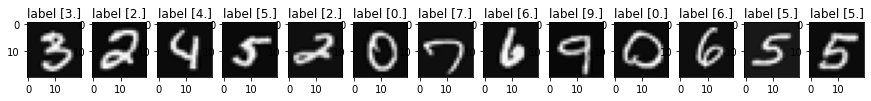

In [ ]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

# Partie 1, régression logistique
Dans cette partie, nous aimerions utiliser la régression logistique pour classifier nos images

Rappelons que la régression logistique nous donne la probabilité d'appartenance (oui ou non) à la classe 1 (elle permet une classification binaire).

Pour étendre la régression logistique à une multi-classification, nous allons utiliser une stratégie 1 contre tous.

Nous paramètres $\theta$ seront donc une matrice avec un nombre de lignes égale au nombre de classes, et avec un nombre de colones égale au nombre decaractéristiques (chaque ligne de la matrice $\theta$ correspond aux paramètres d'un classifieur.

In [ ]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z));

In [ ]:
def lrCostFunction (X, y, initial_theta, alpha, MaxIter,landa):

    theta = initial_theta
    for iter in range( MaxIter):

      hypothesis = Sigmoid(np.dot(X,theta))
      diff = hypothesis-y
      diff_=(X*diff)
      theta[0] = theta[0]  - (1 / m) * alpha *np.sum(diff_[:,0])
      for i in range(1,len(theta)):
        theta[i] = theta[i] * (1 - landa* alpha / m) - (alpha/m) * np.sum(diff_[:,i])
    
    return theta.T


In [ ]:
def predictOnveVsAll (all_theta, X):
    
    y_pred = np.argmax(Sigmoid( np.dot(X,all_theta.T) ), axis=1)
    return y_pred



In [ ]:
classes= np.unique(y)
number_classes=classes.shape[0]
all_theta = np.zeros((number_classes, X.shape[1]));
all_theta.shape

(10, 401)

In [ ]:
MaxIter= 500
lambda_= 0.1
alpha = 0.01
# initial_theta pour chaque classifieur
initial_theta=np.zeros((X.shape[1], 1));
for i in range (number_classes):
     # appel pour chaque classifieur
     theta = lrCostFunction(X,(y==classes[i]).astype(int),initial_theta,alpha, MaxIter,lambda_);

     all_theta[i,:]=theta;                  

In [ ]:
y_pred = predictOnveVsAll(all_theta, X);
print(y_pred)

[0 0 8 ... 4 9 0]


# Qualité du classifieur RL

Prédire des valeurs de y

Ici il serait interessant de calculer la précision de notre classifieur

Essayons de calculer ça avec 

moyenne(y==y-pred) * 100

Ceci donnera un pourcentage de precision

In [ ]:
p=0
for i in range(len(y_pred)):
  if y_pred[i]==y[i]:
    p+=1
precision = p*100/5000
precision



73.98

# Partie 2: Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [ ]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [ ]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [ ]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

**Prédiction**

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [ ]:
def predict (W1, W2, X):
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie

    layer1= Sigmoid(np.dot(X, W1.T))
    X0=np.ones((1,X.shape[0]))
    layer2 = np.insert(layer1,0, X0, axis=1) 
    layer2 = Sigmoid(np.dot(layer2 , W2.T))
    y_pred = np.argmax(layer2, axis=1)
    y_pred = y_pred + 1
    y_pred[y_pred==10] = 0

    return y_pred

In [ ]:
y_pred = predict (W1, W2, X);

In [ ]:
p=0
for i in range(len(y_pred)):
  if y_pred[i]==y[i]:
    p+=1
precision = p*100/5000
precision

97.52

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [ ]:
model = LogisticRegression(penalty="l2", max_iter=10000)
model.fit(X[:, 1:], y.squeeze())
y_prob = model.predict_proba(X[:, 1:])
y_pred = np.argmax(y_prob, axis=1)

p=0
for i in range(len(y_pred)):
  if y_pred[i]==y[i]:
    p+=1
precision = p*100/5000
precision

96.24

# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 22 Avril 2022 à 22h


In [ ]:
# bonne chance